In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [5]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [6]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.9, gamma=0.9, dropout=0.25):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        new_A = F.tanh(F.relu(new_A))
        # new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [7]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [8]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [9]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [10]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls,  epoch, a=0.5, b=1, c=0.02): #modified
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)

    alpha = (1 - np.exp(-c * epoch)) * (a - b) + b #modified

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss #modified
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss
    
def reconstruction_loss_fn(gt_adj, pred_adj):
    l1_loss_fn = nn.L1Loss()
    return l1_loss_fn(gt_adj, pred_adj)

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [12]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=16)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=12)
channels_ls = [32, 64]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


6673868

In [11]:
import gc

def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    #epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
        reconstruction_losses = []
            
        #if (epoch + 1) % 10 == 0:
        #    epoch_weight = # modified


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):
            gc.collect()
            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_loss = down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1])
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_loss = up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], epoch=epoch)
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)

            reconstruction_optimizer.zero_grad()

            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_ls[-1])[-1]
            torch.cuda.empty_cache()

            reconstruction_loss = reconstruction_loss_fn(up_adj_end, adj_hr.to(DEVICE))
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

        
            reconstruction_losses.append(reconstruction_loss.detach().item())
            del reconstruction_loss
            torch.cuda.empty_cache()

            gc.collect()
        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_reconstruction_loss = np.mean(reconstruction_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'ep {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, reconst.loss = {epoch_reconstruction_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [13]:
gc.collect()
up_changer, down_changer, loss_log = train(200, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=0, loss_log=None)

100%|██████████| 11/11 [00:22<00:00,  2.03s/it]


ep 0: down loss = 0.19565032422542572, up loss = 0.15023772553964096, reconst.loss = 0.2808538485657085, down adj mae = 0.2586880854584954, up adj mae = 0.28874450651082123


100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


ep 1: down loss = 0.16343759406696667, up loss = 0.12074285610155626, reconst.loss = 0.24453130228952927, down adj mae = 0.2386215396902778, up adj mae = 0.26138207045468415


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


ep 2: down loss = 0.15230515599250793, up loss = 0.10448252680626782, reconst.loss = 0.22025027871131897, down adj mae = 0.2207829843867909, up adj mae = 0.22590356252410196


100%|██████████| 11/11 [00:19<00:00,  1.76s/it]


ep 3: down loss = 0.14425126937302676, up loss = 0.09391878748481924, reconst.loss = 0.20254754478281195, down adj mae = 0.21218456327915192, up adj mae = 0.21055971086025238


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 4: down loss = 0.13034955818544736, up loss = 0.07898092879490419, reconst.loss = 0.18188065425916153, down adj mae = 0.20468326183882626, up adj mae = 0.1909351430156014


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 5: down loss = 0.11510880833322351, up loss = 0.07154636152765968, reconst.loss = 0.1729053191163323, down adj mae = 0.19997055422176013, up adj mae = 0.18654896996238016


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 6: down loss = 0.10321936282244595, up loss = 0.06487529961900278, reconst.loss = 0.16614394160834225, down adj mae = 0.1865433630618182, up adj mae = 0.17667697776447644


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 7: down loss = 0.09620376269925725, up loss = 0.05980237471786412, reconst.loss = 0.16175240142778916, down adj mae = 0.17839520492336966, up adj mae = 0.16890567947517743


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 8: down loss = 0.09039505367929285, up loss = 0.055583484809507026, reconst.loss = 0.15762316503308035, down adj mae = 0.1742188117720864, up adj mae = 0.16264492544260892


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 9: down loss = 0.0804266706109047, up loss = 0.031850950623100456, reconst.loss = 0.15192750638181513, down adj mae = 0.17159417136148972, up adj mae = 0.1599247631701556


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 10: down loss = 0.07609266550703482, up loss = 0.03134921684183858, reconst.loss = 0.15154601633548737, down adj mae = 0.1638843999667601, up adj mae = 0.15765586224469272


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 11: down loss = 0.07836626131426204, up loss = 0.02921059812334451, reconst.loss = 0.14821010286157782, down adj mae = 0.16580149260434238, up adj mae = 0.15192954377694565


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 12: down loss = 0.07392159070480954, up loss = 0.028721637685190548, reconst.loss = 0.14729181744835593, down adj mae = 0.16159439899704672, up adj mae = 0.15013663470745087


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 13: down loss = 0.07080133868889375, up loss = 0.029728626324371857, reconst.loss = 0.14636083353649487, down adj mae = 0.15707855197516354, up adj mae = 0.15222345157103104


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 14: down loss = 0.06711474602872675, up loss = 0.02760239080949263, reconst.loss = 0.14485371654683893, down adj mae = 0.1535615406253121, up adj mae = 0.14978193017569455


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 15: down loss = 0.0629972636022351, up loss = 0.026762353764338928, reconst.loss = 0.14207390763542868, down adj mae = 0.15461649136109787, up adj mae = 0.14708370376716962


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 16: down loss = 0.06308397142724557, up loss = 0.027004590596665035, reconst.loss = 0.1430913440205834, down adj mae = 0.15416746789758856, up adj mae = 0.1466324044899507


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 17: down loss = 0.06048277122053233, up loss = 0.027168545533310284, reconst.loss = 0.1436637355522676, down adj mae = 0.14965066449208694, up adj mae = 0.1469670615412972


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 18: down loss = 0.06372895362702283, up loss = 0.0277764191004363, reconst.loss = 0.14430456405336206, down adj mae = 0.15364016592502594, up adj mae = 0.1506448428739201


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 19: down loss = 0.06052861362695694, up loss = 0.02674642171372067, reconst.loss = 0.1421519707549702, down adj mae = 0.1498869007283991, up adj mae = 0.14525977996262637


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 20: down loss = 0.061572063375603066, up loss = 0.02751921574500474, reconst.loss = 0.14396389777010138, down adj mae = 0.14789395169778305, up adj mae = 0.14656825770031323


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 21: down loss = 0.057938063009218735, up loss = 0.02626694586466659, reconst.loss = 0.14209769395264712, down adj mae = 0.1461418799378655, up adj mae = 0.14435011961243369


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 22: down loss = 0.05583880266005343, up loss = 0.026802854781801052, reconst.loss = 0.14296766302802347, down adj mae = 0.14865931462157855, up adj mae = 0.14523772759871048


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 23: down loss = 0.0543468255888332, up loss = 0.02642851136624813, reconst.loss = 0.1419602930545807, down adj mae = 0.1470325602726503, up adj mae = 0.14503814009102908


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 24: down loss = 0.05380874398079785, up loss = 0.02645074406808073, reconst.loss = 0.14137866686690936, down adj mae = 0.14517151361162012, up adj mae = 0.14373572035269302


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 25: down loss = 0.055496385490352455, up loss = 0.025952774354002693, reconst.loss = 0.14106339080767197, down adj mae = 0.14953904124823483, up adj mae = 0.14347204566001892


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 26: down loss = 0.05267169868404215, up loss = 0.025716400959274986, reconst.loss = 0.13945418731732803, down adj mae = 0.143715193325823, up adj mae = 0.141320448030125


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 27: down loss = 0.05163545703346079, up loss = 0.025277795778079468, reconst.loss = 0.13936934958804736, down adj mae = 0.14575779844414105, up adj mae = 0.14353913475166669


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 28: down loss = 0.05034131793813272, up loss = 0.02475934644991701, reconst.loss = 0.13929289850321683, down adj mae = 0.14570083672350104, up adj mae = 0.14008098163387991


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 29: down loss = 0.050613563169132576, up loss = 0.024612540379166603, reconst.loss = 0.13852459192276, down adj mae = 0.14318472011522812, up adj mae = 0.137917314063419


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 30: down loss = 0.0498301816934889, up loss = 0.024454399435357613, reconst.loss = 0.13719728724523025, down adj mae = 0.14026373353871432, up adj mae = 0.13824963163245807


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 31: down loss = 0.05039952153509313, up loss = 0.024435165253552524, reconst.loss = 0.13720646771517667, down adj mae = 0.1405834840102629, up adj mae = 0.13859167153185065


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 32: down loss = 0.05290858515284278, up loss = 0.025801642374558884, reconst.loss = 0.13876439360055057, down adj mae = 0.14120563187382437, up adj mae = 0.13780101050030102


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 33: down loss = 0.05595073137771, up loss = 0.02935599061575803, reconst.loss = 0.14260319552638315, down adj mae = 0.14482104100964285, up adj mae = 0.14849932898174634


100%|██████████| 11/11 [00:16<00:00,  1.55s/it]


ep 34: down loss = 0.05453034219416705, up loss = 0.02473268454725092, reconst.loss = 0.13879453458569266, down adj mae = 0.1402554132721641, up adj mae = 0.14050132848999716


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 35: down loss = 0.05297125740484758, up loss = 0.02434966696256941, reconst.loss = 0.13685849038037387, down adj mae = 0.13930469209497626, up adj mae = 0.14014196395874023


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 36: down loss = 0.05192421478303996, up loss = 0.026197331703521988, reconst.loss = 0.1430184759876945, down adj mae = 0.14209004152904858, up adj mae = 0.14361398870294745


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 37: down loss = 0.050313963131471115, up loss = 0.024556607685305855, reconst.loss = 0.13793094049800525, down adj mae = 0.13893473012880844, up adj mae = 0.1376594833352349


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 38: down loss = 0.04991229555823586, up loss = 0.024254872378977863, reconst.loss = 0.13698372515765103, down adj mae = 0.14530788632956418, up adj mae = 0.13967018506743692


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 39: down loss = 0.049660786309025505, up loss = 0.0238380300050432, reconst.loss = 0.13604007796807724, down adj mae = 0.14229132776910608, up adj mae = 0.13911417397585782


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 40: down loss = 0.04941763220862909, up loss = 0.024048123847354542, reconst.loss = 0.1365034742788835, down adj mae = 0.1402050649577921, up adj mae = 0.13619877939874475


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 41: down loss = 0.046430804512717506, up loss = 0.023992002857002346, reconst.loss = 0.13544816726988013, down adj mae = 0.1388393207029863, up adj mae = 0.13604278997941452


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 42: down loss = 0.04783393002369187, up loss = 0.024646643379872494, reconst.loss = 0.13661166348240592, down adj mae = 0.14007833735509354, up adj mae = 0.13961363651535727


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 43: down loss = 0.04485283656553789, up loss = 0.02490556968206709, reconst.loss = 0.137238778851249, down adj mae = 0.13674602860754187, up adj mae = 0.13738305324857886


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 44: down loss = 0.04458544301715764, up loss = 0.02413071421059695, reconst.loss = 0.13586815107952466, down adj mae = 0.13923630660230463, up adj mae = 0.13463933765888214


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 45: down loss = 0.04386123235930096, up loss = 0.02338628928092393, reconst.loss = 0.1349782022562894, down adj mae = 0.1352725015445189, up adj mae = 0.13427057591351596


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 46: down loss = 0.04217467490922321, up loss = 0.023000564087520946, reconst.loss = 0.13373623517426578, down adj mae = 0.13714966042475266, up adj mae = 0.13470287079160864


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 47: down loss = 0.04338950731537559, up loss = 0.023437937213615936, reconst.loss = 0.1344694955782457, down adj mae = 0.13523583859205246, up adj mae = 0.13549422134052624


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 48: down loss = 0.04437955807555805, up loss = 0.02357747033238411, reconst.loss = 0.1355272815986113, down adj mae = 0.1398694014007395, up adj mae = 0.136341162703254


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 49: down loss = 0.042481374334205284, up loss = 0.023105819286270576, reconst.loss = 0.13391065868464383, down adj mae = 0.13489568504420194, up adj mae = 0.13344118270007047


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 50: down loss = 0.042978059500455856, up loss = 0.02287807163189758, reconst.loss = 0.13410124724561517, down adj mae = 0.13796184144236825, up adj mae = 0.1361934312365272


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 51: down loss = 0.040664581073956055, up loss = 0.02268313616514206, reconst.loss = 0.13256993347948248, down adj mae = 0.13604919612407684, up adj mae = 0.13558924401348288


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 52: down loss = 0.04076868735931136, up loss = 0.0229079510000619, reconst.loss = 0.13350402360612695, down adj mae = 0.13612189211628653, up adj mae = 0.1356023441661488


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 53: down loss = 0.040897701951590454, up loss = 0.023080212995409966, reconst.loss = 0.13406392119147562, down adj mae = 0.13590487905523993, up adj mae = 0.13529864156788046


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 54: down loss = 0.041376997462727806, up loss = 0.023117825050245632, reconst.loss = 0.13470142537897284, down adj mae = 0.13762786848978562, up adj mae = 0.1362078474326567


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 55: down loss = 0.04586961797692559, up loss = 0.023610266264189373, reconst.loss = 0.1350741765715859, down adj mae = 0.13725192709402603, up adj mae = 0.1378273679451509


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 56: down loss = 0.0420542796227065, up loss = 0.022709395736455917, reconst.loss = 0.1325589120388031, down adj mae = 0.13951987569982355, up adj mae = 0.13757469776001843


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 57: down loss = 0.04168314825404774, up loss = 0.02279757809909907, reconst.loss = 0.1335372884165157, down adj mae = 0.13406433436003598, up adj mae = 0.13378091021017594


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 58: down loss = 0.04209590838714079, up loss = 0.022631205110387367, reconst.loss = 0.13372533294287595, down adj mae = 0.13479184833439914, up adj mae = 0.13459664583206177


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 59: down loss = 0.0424661555073478, up loss = 0.022847567600282757, reconst.loss = 0.1334772069345821, down adj mae = 0.13306296752257782, up adj mae = 0.13316988267681815


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 60: down loss = 0.04107377034696666, up loss = 0.022507081654938785, reconst.loss = 0.13318665732036938, down adj mae = 0.1351310502399098, up adj mae = 0.13187605278058487


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 61: down loss = 0.04150276360186664, up loss = 0.02284757454286922, reconst.loss = 0.13268990137360312, down adj mae = 0.13667527518489145, up adj mae = 0.13564708557995883


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 62: down loss = 0.04057387838309461, up loss = 0.02267848395488479, reconst.loss = 0.1328319636258212, down adj mae = 0.13932972198182886, up adj mae = 0.13471563837744974


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 63: down loss = 0.041600778698921204, up loss = 0.022881634533405304, reconst.loss = 0.1332154409451918, down adj mae = 0.1369778500361876, up adj mae = 0.13590679249980234


100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


ep 64: down loss = 0.04073435135863044, up loss = 0.022207217968323013, reconst.loss = 0.13210742311044174, down adj mae = 0.1400740539485758, up adj mae = 0.13423669744621625


100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


ep 65: down loss = 0.041123694655570114, up loss = 0.022761288352987984, reconst.loss = 0.13229379870674826, down adj mae = 0.1365725641900843, up adj mae = 0.1349803696979176


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 66: down loss = 0.0405472188510678, up loss = 0.022940910336646168, reconst.loss = 0.13353869183496994, down adj mae = 0.13573960824446243, up adj mae = 0.13490266285159372


100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


ep 67: down loss = 0.04053028571334752, up loss = 0.022230777381495995, reconst.loss = 0.1320356699553403, down adj mae = 0.1373885070735758, up adj mae = 0.13580491867932407


100%|██████████| 11/11 [00:19<00:00,  1.76s/it]


ep 68: down loss = 0.03938135809519074, up loss = 0.02233528278090737, reconst.loss = 0.1316203217614781, down adj mae = 0.13671931624412537, up adj mae = 0.13518731702457776


100%|██████████| 11/11 [00:19<00:00,  1.76s/it]


ep 69: down loss = 0.03885455700484189, up loss = 0.022379433058879593, reconst.loss = 0.13237790763378143, down adj mae = 0.13442474603652954, up adj mae = 0.13447398556904358


100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


ep 70: down loss = 0.039185459302230316, up loss = 0.02208094112575054, reconst.loss = 0.1317206688902595, down adj mae = 0.13322070986032486, up adj mae = 0.13210870257832788


100%|██████████| 11/11 [00:18<00:00,  1.73s/it]


ep 71: down loss = 0.0401701381938024, up loss = 0.022228639234196056, reconst.loss = 0.1318018897013231, down adj mae = 0.13532929190180518, up adj mae = 0.1339528580958193


100%|██████████| 11/11 [00:18<00:00,  1.73s/it]


ep 72: down loss = 0.03950905765999447, up loss = 0.021847918290983547, reconst.loss = 0.13066368753259833, down adj mae = 0.1356553855267438, up adj mae = 0.13227479633959857


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 73: down loss = 0.03915663808584213, up loss = 0.021634806455536323, reconst.loss = 0.13050390102646567, down adj mae = 0.13595207035541534, up adj mae = 0.12977584180506793


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 74: down loss = 0.039909431541507896, up loss = 0.021721256727522068, reconst.loss = 0.1306713345375928, down adj mae = 0.1370879357511347, up adj mae = 0.1322417685931379


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 75: down loss = 0.03840168159116398, up loss = 0.021906826983798634, reconst.loss = 0.13041591915217313, down adj mae = 0.13541906801137057, up adj mae = 0.13133818453008478


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 76: down loss = 0.03891505571928891, up loss = 0.02212006768042391, reconst.loss = 0.13117809729142624, down adj mae = 0.13599656522274017, up adj mae = 0.1310256225141612


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 77: down loss = 0.03980174491351301, up loss = 0.022789365188641983, reconst.loss = 0.13263544711199673, down adj mae = 0.14239554107189178, up adj mae = 0.134294638579542


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 78: down loss = 0.03894831815903837, up loss = 0.022307412190870804, reconst.loss = 0.13218922506679187, down adj mae = 0.1389675275845961, up adj mae = 0.1313085989518599


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 79: down loss = 0.03874199160120704, up loss = 0.022092463617975063, reconst.loss = 0.13058158213442023, down adj mae = 0.13472814587029544, up adj mae = 0.12977023287252945


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 80: down loss = 0.040340300649404526, up loss = 0.022696060382507065, reconst.loss = 0.1310336867516691, down adj mae = 0.1350960209965706, up adj mae = 0.132067702033303


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 81: down loss = 0.03828192299062556, up loss = 0.02216309258206324, reconst.loss = 0.13148327036337418, down adj mae = 0.13616905022751202, up adj mae = 0.13167126341299576


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 82: down loss = 0.03730160438201644, up loss = 0.021946443075483494, reconst.loss = 0.1314538378607143, down adj mae = 0.13255945322188464, up adj mae = 0.13025165010582318


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 83: down loss = 0.03942044147036292, up loss = 0.022081260992722077, reconst.loss = 0.13097376985983414, down adj mae = 0.134076750413938, up adj mae = 0.13302319361404938


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 84: down loss = 0.03756195679306984, up loss = 0.02193630232729695, reconst.loss = 0.13149772787635977, down adj mae = 0.13380480760877783, up adj mae = 0.13138961791992188


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 85: down loss = 0.03666339679197832, up loss = 0.021489867940545082, reconst.loss = 0.1299323480237614, down adj mae = 0.13552485406398773, up adj mae = 0.13112076304175638


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 86: down loss = 0.03721907633272084, up loss = 0.021550264040177517, reconst.loss = 0.12990446862849322, down adj mae = 0.1334150338714773, up adj mae = 0.13032688403671439


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 87: down loss = 0.036937661807645454, up loss = 0.021442816000093113, reconst.loss = 0.1296687600287524, down adj mae = 0.13451759652657944, up adj mae = 0.13223311575976285


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 88: down loss = 0.036505446515300057, up loss = 0.02163893695582043, reconst.loss = 0.13063113730062137, down adj mae = 0.1335684352300384, up adj mae = 0.12906783683733505


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 89: down loss = 0.03587824580344287, up loss = 0.02114567228338935, reconst.loss = 0.1294605786150152, down adj mae = 0.13684249195185574, up adj mae = 0.13031915642998435


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 90: down loss = 0.03581067581068386, up loss = 0.02128363942558115, reconst.loss = 0.128721146420999, down adj mae = 0.1362999826669693, up adj mae = 0.12799012864177878


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 91: down loss = 0.03505237197334116, up loss = 0.021676701070232826, reconst.loss = 0.13030852512879806, down adj mae = 0.13700039955702695, up adj mae = 0.13158836825327438


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 92: down loss = 0.03545881977135485, up loss = 0.021702805703336544, reconst.loss = 0.12926899777217346, down adj mae = 0.13303964178670535, up adj mae = 0.12878321517597546


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 93: down loss = 0.0352562621913173, up loss = 0.021607200530442325, reconst.loss = 0.13009064983237872, down adj mae = 0.1365462284196507, up adj mae = 0.13463929160074753


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 94: down loss = 0.03481826287778941, up loss = 0.021385071121833542, reconst.loss = 0.12919149547815323, down adj mae = 0.1345244361595674, up adj mae = 0.13185893270102414


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 95: down loss = 0.03442627191543579, up loss = 0.0211507628925822, reconst.loss = 0.12872346897016873, down adj mae = 0.13606561449441043, up adj mae = 0.13102210787209598


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 96: down loss = 0.03494908254254948, up loss = 0.021092998202551495, reconst.loss = 0.12932244756005026, down adj mae = 0.1370965540409088, up adj mae = 0.1293664811687036


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 97: down loss = 0.03481766717000441, up loss = 0.021214875307950107, reconst.loss = 0.128731678832661, down adj mae = 0.13691009039228613, up adj mae = 0.13208843293515118


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 98: down loss = 0.03478322381323034, up loss = 0.02105264060876586, reconst.loss = 0.12879969721490686, down adj mae = 0.13547087663953955, up adj mae = 0.1318280744281682


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 99: down loss = 0.034805422818118874, up loss = 0.02110935358161276, reconst.loss = 0.12836316295645453, down adj mae = 0.1382731788537719, up adj mae = 0.13175627047365362


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 100: down loss = 0.03455135903575204, up loss = 0.0211322158575058, reconst.loss = 0.12921554324301807, down adj mae = 0.1327965659174052, up adj mae = 0.13175459747964685


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 101: down loss = 0.033846414224667984, up loss = 0.020865699445659466, reconst.loss = 0.1283942013978958, down adj mae = 0.13555407185446133, up adj mae = 0.13086589899930087


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 102: down loss = 0.034837425432421944, up loss = 0.021080984818664463, reconst.loss = 0.12907181070609527, down adj mae = 0.1339695765213533, up adj mae = 0.128317039121281


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 103: down loss = 0.03488360311497341, up loss = 0.021272509612820366, reconst.loss = 0.1280213167721575, down adj mae = 0.13285595652731982, up adj mae = 0.12706495279615576


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 104: down loss = 0.03488497876308181, up loss = 0.021070120178840378, reconst.loss = 0.1288978620008989, down adj mae = 0.13518285751342773, up adj mae = 0.13005235655741257


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 105: down loss = 0.03439785438505086, up loss = 0.02102405713363127, reconst.loss = 0.12801137566566467, down adj mae = 0.13634605570272965, up adj mae = 0.1294335424900055


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 106: down loss = 0.03496021675792607, up loss = 0.020947221158580345, reconst.loss = 0.12812431833960794, down adj mae = 0.13627509569579904, up adj mae = 0.1302058378403837


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 107: down loss = 0.03444928235628388, up loss = 0.02142923071303151, reconst.loss = 0.12798535891554572, down adj mae = 0.13768484646623785, up adj mae = 0.1331921721046621


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 108: down loss = 0.035504049198193985, up loss = 0.02121351862495596, reconst.loss = 0.12863761051134628, down adj mae = 0.13153379207307642, up adj mae = 0.1303221502087333


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 109: down loss = 0.034914826466278595, up loss = 0.02105095237493515, reconst.loss = 0.1277017816901207, down adj mae = 0.1359267234802246, up adj mae = 0.12931233034892517


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 110: down loss = 0.03456681391054934, up loss = 0.020558936182748188, reconst.loss = 0.12713987854394046, down adj mae = 0.13584884052926843, up adj mae = 0.1295047795230692


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 111: down loss = 0.03448586402968927, up loss = 0.021356977183710445, reconst.loss = 0.12893820824948224, down adj mae = 0.1319894181056456, up adj mae = 0.12927303937348453


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 112: down loss = 0.03418900478969921, up loss = 0.02133445255458355, reconst.loss = 0.12810948558829047, down adj mae = 0.13585066388953815, up adj mae = 0.1306528686122461


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 113: down loss = 0.036256343803622505, up loss = 0.021975893357937985, reconst.loss = 0.12917785075577823, down adj mae = 0.13585169884291562, up adj mae = 0.13238631730729883


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 114: down loss = 0.035361589017239486, up loss = 0.021366136995228855, reconst.loss = 0.12674183398485184, down adj mae = 0.13390981338240884, up adj mae = 0.13118282705545425


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 115: down loss = 0.037583761594512245, up loss = 0.022062091326171703, reconst.loss = 0.13047253001819958, down adj mae = 0.13908447189764542, up adj mae = 0.132597147741101


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 116: down loss = 0.03597358986735344, up loss = 0.02106861194426363, reconst.loss = 0.12797994302077728, down adj mae = 0.13297594745050778, up adj mae = 0.13059821183031256


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 117: down loss = 0.035203158178112724, up loss = 0.021794087676839394, reconst.loss = 0.1290661943229762, down adj mae = 0.13737728108059277, up adj mae = 0.13255252892320807


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 118: down loss = 0.03486910394646905, up loss = 0.020567936484109272, reconst.loss = 0.127218749712814, down adj mae = 0.13320881805636667, up adj mae = 0.12767841870134528


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 119: down loss = 0.0338201109658588, up loss = 0.02042060582475229, reconst.loss = 0.12655687128955667, down adj mae = 0.13552989742972635, up adj mae = 0.12864018028432672


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 120: down loss = 0.033939077434214676, up loss = 0.02083677425980568, reconst.loss = 0.12612423368475653, down adj mae = 0.13395043868910184, up adj mae = 0.12918369336561722


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 121: down loss = 0.03397238390012221, up loss = 0.020481653850186955, reconst.loss = 0.12691084363243796, down adj mae = 0.1328249153765765, up adj mae = 0.12772719020193274


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 122: down loss = 0.033791287717494095, up loss = 0.02030222439630465, reconst.loss = 0.12537243284962393, down adj mae = 0.13460120287808505, up adj mae = 0.12781096656214108


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 123: down loss = 0.033536392856727944, up loss = 0.02044051546942104, reconst.loss = 0.12659412080591376, down adj mae = 0.13563895360990005, up adj mae = 0.12837151979858225


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 124: down loss = 0.03398594734343616, up loss = 0.019885820082642815, reconst.loss = 0.12505532462488522, down adj mae = 0.13149770078333942, up adj mae = 0.1273681324991313


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 125: down loss = 0.03314576399597255, up loss = 0.019979218021035194, reconst.loss = 0.12435097044164484, down adj mae = 0.1332660893147642, up adj mae = 0.12464407695965334


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 126: down loss = 0.03344574435190721, up loss = 0.020033147524703632, reconst.loss = 0.12507092546332965, down adj mae = 0.1322189149531451, up adj mae = 0.12775062769651413


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 127: down loss = 0.033364021303978836, up loss = 0.019948337396437473, reconst.loss = 0.1242880719629201, down adj mae = 0.13346142931417984, up adj mae = 0.1258264739405025


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 128: down loss = 0.03339950130744414, up loss = 0.019795181568373333, reconst.loss = 0.12428692254153165, down adj mae = 0.13398357142101636, up adj mae = 0.1268903132189404


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 129: down loss = 0.033531402999704536, up loss = 0.019967835904522377, reconst.loss = 0.12445306913419203, down adj mae = 0.1346291574564847, up adj mae = 0.1273739202456041


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 130: down loss = 0.03354712575674057, up loss = 0.01965709301558408, reconst.loss = 0.12386967241764069, down adj mae = 0.13388504494320264, up adj mae = 0.12355808371847327


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 131: down loss = 0.03513526306910948, up loss = 0.020609013566916638, reconst.loss = 0.125330119647763, down adj mae = 0.13516077873381702, up adj mae = 0.12859532033855264


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 132: down loss = 0.03464349901134318, up loss = 0.01999539052220908, reconst.loss = 0.12414604696360501, down adj mae = 0.13109065185893665, up adj mae = 0.12496065416119316


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 133: down loss = 0.03377129442312501, up loss = 0.019689770923419433, reconst.loss = 0.12394970452243631, down adj mae = 0.1325219679962505, up adj mae = 0.12546475502577695


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 134: down loss = 0.0340846333314072, up loss = 0.01997352069751783, reconst.loss = 0.12381274727257816, down adj mae = 0.13345641575076364, up adj mae = 0.12586434524167667


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 135: down loss = 0.03468320383266969, up loss = 0.020248248157176105, reconst.loss = 0.12551327659325165, down adj mae = 0.1347461613741788, up adj mae = 0.12689577652649445


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 136: down loss = 0.03463795781135559, up loss = 0.020062973722815514, reconst.loss = 0.12386447326703505, down adj mae = 0.1323281546885317, up adj mae = 0.1255304996262897


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 137: down loss = 0.03430988063866442, up loss = 0.019798127257011154, reconst.loss = 0.124104612252929, down adj mae = 0.1348503746769645, up adj mae = 0.12483983622355894


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 138: down loss = 0.03408262404528531, up loss = 0.019643862816420467, reconst.loss = 0.12304239449175922, down adj mae = 0.13473709604956888, up adj mae = 0.1263564249331301


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 139: down loss = 0.0344139967452396, up loss = 0.01974393410438841, reconst.loss = 0.12353057414293289, down adj mae = 0.1331600397825241, up adj mae = 0.12499470941045067


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 140: down loss = 0.03425379774787209, up loss = 0.01951991089365699, reconst.loss = 0.1226601620966738, down adj mae = 0.13273015211928973, up adj mae = 0.12242614816535603


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 141: down loss = 0.03418871455571868, up loss = 0.019508234817873348, reconst.loss = 0.12265808067538521, down adj mae = 0.13538212871009653, up adj mae = 0.12599729001522064


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 142: down loss = 0.03365647792816162, up loss = 0.018999701196497135, reconst.loss = 0.12159072201360356, down adj mae = 0.13504220274361697, up adj mae = 0.1238923127000982


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 143: down loss = 0.033722018992358986, up loss = 0.018672119995409794, reconst.loss = 0.1205884265628728, down adj mae = 0.13197531347925012, up adj mae = 0.12127085842869499


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 144: down loss = 0.03396528112617406, up loss = 0.0183892756361853, reconst.loss = 0.11996211517940868, down adj mae = 0.13790315118702975, up adj mae = 0.12146096134727652


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 145: down loss = 0.03356878323988481, up loss = 0.01851592839441516, reconst.loss = 0.12017437612468546, down adj mae = 0.14242734150453049, up adj mae = 0.12324555692347614


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 146: down loss = 0.03353243456645445, up loss = 0.018719529394399036, reconst.loss = 0.12070507488467476, down adj mae = 0.13236977295442062, up adj mae = 0.12239776483990929


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 147: down loss = 0.033649243753064766, up loss = 0.018695551055398853, reconst.loss = 0.12083525413816626, down adj mae = 0.13828413527120242, up adj mae = 0.12225958095355467


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 148: down loss = 0.03392767567526211, up loss = 0.01845712892033837, reconst.loss = 0.12000509080561725, down adj mae = 0.13633837076750668, up adj mae = 0.12102082574909384


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 149: down loss = 0.03388828445564617, up loss = 0.018365804275328464, reconst.loss = 0.11994388970461758, down adj mae = 0.13532077859748493, up adj mae = 0.12058551067655737


100%|██████████| 11/11 [00:19<00:00,  1.76s/it]


ep 150: down loss = 0.033640233291821045, up loss = 0.018158470195802776, reconst.loss = 0.11911037022417242, down adj mae = 0.13186810165643692, up adj mae = 0.11806404387409036


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 151: down loss = 0.03388161279938438, up loss = 0.01826351491565054, reconst.loss = 0.1191899458115751, down adj mae = 0.1328619420528412, up adj mae = 0.12081827358766035


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 152: down loss = 0.03349661894819953, up loss = 0.018115730956196785, reconst.loss = 0.11834548481486061, down adj mae = 0.13036397776820444, up adj mae = 0.1186071898449551


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 153: down loss = 0.03379871730100025, up loss = 0.018113215030594307, reconst.loss = 0.1183262670581991, down adj mae = 0.13245668871836228, up adj mae = 0.11944631961258975


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 154: down loss = 0.03350166942585598, up loss = 0.018061254173517227, reconst.loss = 0.11792189086025412, down adj mae = 0.13379772210663016, up adj mae = 0.12021382762627168


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 155: down loss = 0.03351410173557021, up loss = 0.017870023677294903, reconst.loss = 0.11742940951477397, down adj mae = 0.13719575648958032, up adj mae = 0.11939867518164894


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 156: down loss = 0.03353716805577278, up loss = 0.017958197742700577, reconst.loss = 0.11764110218394887, down adj mae = 0.13327841054309497, up adj mae = 0.11914883283051578


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 157: down loss = 0.03400342268022624, up loss = 0.017725883051753044, reconst.loss = 0.11665347692641345, down adj mae = 0.13264878703789276, up adj mae = 0.1173438775268468


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 158: down loss = 0.03379947150295431, up loss = 0.018055624413219364, reconst.loss = 0.11728358946063301, down adj mae = 0.13416181775656613, up adj mae = 0.1198511313308369


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 159: down loss = 0.03367199850353328, up loss = 0.017665363509546627, reconst.loss = 0.11651943759484724, down adj mae = 0.13399249450726944, up adj mae = 0.11618324504657225


100%|██████████| 11/11 [00:18<00:00,  1.73s/it]


ep 160: down loss = 0.03424849699844013, up loss = 0.017717595466158607, reconst.loss = 0.11664702201431448, down adj mae = 0.1297094476493922, up adj mae = 0.1160260330546986


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 161: down loss = 0.03372429379008033, up loss = 0.017518903975459663, reconst.loss = 0.11580146984620528, down adj mae = 0.1405316333879124, up adj mae = 0.11841819367625496


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 162: down loss = 0.03362266075882045, up loss = 0.017247947271574627, reconst.loss = 0.11491711031306874, down adj mae = 0.13322846320542422, up adj mae = 0.1170938482338732


100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


ep 163: down loss = 0.03348116796802391, up loss = 0.017293373122811317, reconst.loss = 0.11498140746896918, down adj mae = 0.13655582476745953, up adj mae = 0.1179207217964259


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 164: down loss = 0.033884018659591675, up loss = 0.018019073727456005, reconst.loss = 0.11723365566947243, down adj mae = 0.13361861353570764, up adj mae = 0.11792979660359296


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 165: down loss = 0.03420805727893656, up loss = 0.01754177277061072, reconst.loss = 0.11567698960954492, down adj mae = 0.1369139091535048, up adj mae = 0.1199483722448349


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 166: down loss = 0.03365481170740994, up loss = 0.016986725259233604, reconst.loss = 0.11390644244172356, down adj mae = 0.13523575257171283, up adj mae = 0.1164036366072568


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 167: down loss = 0.033471795645627106, up loss = 0.01717645370147445, reconst.loss = 0.11392013728618622, down adj mae = 0.1338602670214393, up adj mae = 0.11552543870427391


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 168: down loss = 0.03401729362932118, up loss = 0.017008023336529732, reconst.loss = 0.11368973553180695, down adj mae = 0.1313232793049379, up adj mae = 0.11419961262832988


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 169: down loss = 0.03382809595628218, up loss = 0.01680147275328636, reconst.loss = 0.11272690919312564, down adj mae = 0.13275990228761325, up adj mae = 0.11429976130073721


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 170: down loss = 0.034030194986950264, up loss = 0.016680436886169693, reconst.loss = 0.11226631700992584, down adj mae = 0.13490944762121548, up adj mae = 0.11295796727592294


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 171: down loss = 0.034177390350536865, up loss = 0.016762849112803287, reconst.loss = 0.11278725144538013, down adj mae = 0.13277053968472916, up adj mae = 0.1147140393202955


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 172: down loss = 0.033805883743546226, up loss = 0.016811446625400673, reconst.loss = 0.11223606900735335, down adj mae = 0.1351435895670544, up adj mae = 0.11543949354778636


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 173: down loss = 0.03399749201807109, up loss = 0.016347439197654075, reconst.loss = 0.11125271699645302, down adj mae = 0.13252489268779755, up adj mae = 0.11296308176083998


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 174: down loss = 0.033726522529667076, up loss = 0.01619409549642693, reconst.loss = 0.11028939621015028, down adj mae = 0.13618912615559317, up adj mae = 0.11243370243094185


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 175: down loss = 0.03423912112008442, up loss = 0.016666977920315483, reconst.loss = 0.11134812100367113, down adj mae = 0.1360817077484998, up adj mae = 0.11330131509087303


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 176: down loss = 0.034218391572887245, up loss = 0.016476042738015003, reconst.loss = 0.11111010814254935, down adj mae = 0.13732899048111655, up adj mae = 0.1151814650405537


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 177: down loss = 0.03416917710141702, up loss = 0.01629939836195924, reconst.loss = 0.11047974635254253, down adj mae = 0.13910721106962723, up adj mae = 0.1121302761814811


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 178: down loss = 0.03380203518000516, up loss = 0.01587345865978436, reconst.loss = 0.10865326903083107, down adj mae = 0.1307645711031827, up adj mae = 0.10825553468682549


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 179: down loss = 0.03403297337618741, up loss = 0.016203462908213787, reconst.loss = 0.10976088317957791, down adj mae = 0.13654329153624448, up adj mae = 0.11122373897920955


100%|██████████| 11/11 [00:18<00:00,  1.73s/it]


ep 180: down loss = 0.03376107493584806, up loss = 0.01582695662297986, reconst.loss = 0.10813068124380978, down adj mae = 0.12901516258716583, up adj mae = 0.10842098702083934


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 181: down loss = 0.03346567567099224, up loss = 0.015811084769666195, reconst.loss = 0.10798923468047922, down adj mae = 0.1352610859003934, up adj mae = 0.11104148626327515


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 182: down loss = 0.03380349786444144, up loss = 0.01594909754666415, reconst.loss = 0.1081365475600416, down adj mae = 0.13188537887551569, up adj mae = 0.10944032059474425


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 183: down loss = 0.033540140160105446, up loss = 0.01569003417071971, reconst.loss = 0.10760274123061787, down adj mae = 0.13478702713142743, up adj mae = 0.11057913303375244


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 184: down loss = 0.0337325165217573, up loss = 0.015601300465112383, reconst.loss = 0.10688652978702025, down adj mae = 0.13107004219835455, up adj mae = 0.10790094326842915


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 185: down loss = 0.03407994082028216, up loss = 0.01575159298425371, reconst.loss = 0.1073208363218741, down adj mae = 0.13673029839992523, up adj mae = 0.1102757758714936


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 186: down loss = 0.033853897655552086, up loss = 0.015807611275125633, reconst.loss = 0.10709345543926413, down adj mae = 0.13272852992469614, up adj mae = 0.10873706164685162


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 187: down loss = 0.03381275453350761, up loss = 0.014999357983469963, reconst.loss = 0.10511480678211559, down adj mae = 0.13269220698963513, up adj mae = 0.10632156919349324


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 188: down loss = 0.03343727642839605, up loss = 0.015215609730644659, reconst.loss = 0.10509684072299437, down adj mae = 0.1347219388593327, up adj mae = 0.1069019768725742


100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


ep 189: down loss = 0.03404886038465933, up loss = 0.015104366381737318, reconst.loss = 0.10499045591462743, down adj mae = 0.13566839017651297, up adj mae = 0.10692634839903224


100%|██████████| 11/11 [00:18<00:00,  1.73s/it]


ep 190: down loss = 0.033883856440132316, up loss = 0.014643901705064556, reconst.loss = 0.10352210835977034, down adj mae = 0.13712453164837576, up adj mae = 0.10468216375871138


100%|██████████| 11/11 [00:18<00:00,  1.73s/it]


ep 191: down loss = 0.033688334240154785, up loss = 0.014838616617701271, reconst.loss = 0.10337193852121179, down adj mae = 0.13952584564685822, up adj mae = 0.10514425824988972


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 192: down loss = 0.0338368679989468, up loss = 0.014784851788797161, reconst.loss = 0.10381791740655899, down adj mae = 0.13498126783154227, up adj mae = 0.10578952797434547


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 193: down loss = 0.03352778811346401, up loss = 0.01457164047116583, reconst.loss = 0.10285904055291956, down adj mae = 0.13458834453062576, up adj mae = 0.10363593155687506


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 194: down loss = 0.033210714093663475, up loss = 0.014399451034312899, reconst.loss = 0.10218020325357263, down adj mae = 0.13491633940826764, up adj mae = 0.10351217809048566


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 195: down loss = 0.033464269881898705, up loss = 0.014340185390954668, reconst.loss = 0.10164521092718298, down adj mae = 0.1318606991659511, up adj mae = 0.1037388640371236


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 196: down loss = 0.033431766724044625, up loss = 0.014184295369142836, reconst.loss = 0.10127466239712456, down adj mae = 0.13317738270217722, up adj mae = 0.10268575020811775


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 197: down loss = 0.0335822000422261, up loss = 0.014344270171766932, reconst.loss = 0.10156495462764394, down adj mae = 0.13417930901050568, up adj mae = 0.10284513844685121


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 198: down loss = 0.03310160135680979, up loss = 0.014088246548040346, reconst.loss = 0.10056763751940294, down adj mae = 0.1346082924441858, up adj mae = 0.10147753899747675


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]

ep 199: down loss = 0.03332713483409448, up loss = 0.014088626696982166, reconst.loss = 0.10046644915233958, down adj mae = 0.13507240536538037, up adj mae = 0.10268196124922145


In [14]:
min(loss_log['up_end_mae'])

0.10147753899747675

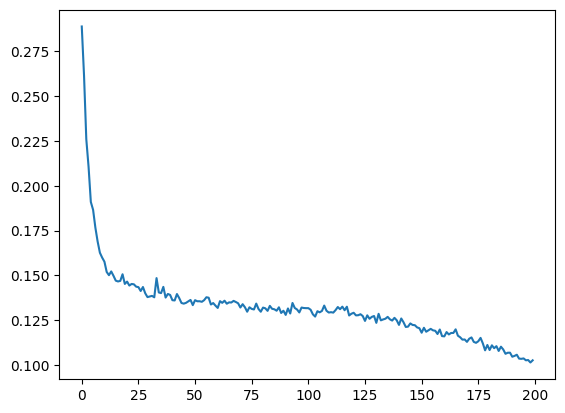

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [21]:
torch.save(up_changer.state_dict(), 'submission_files/moritz_deep4/old_scheduler_tanhrelu.pth')

In [19]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


In [20]:
torch.save(test_predictions, 'submission_files/moritz_deep4/old_scheduler_tanhrelu.pt')

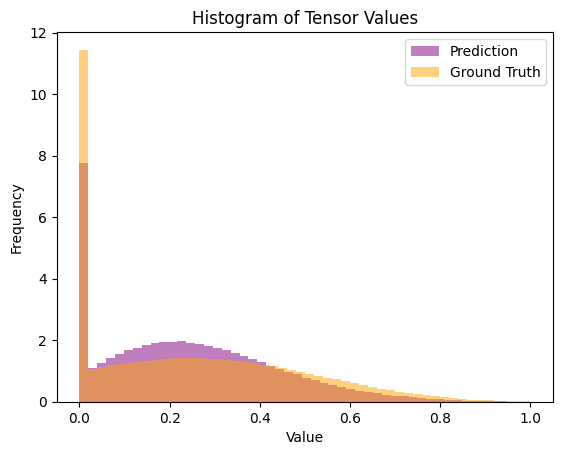

In [18]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

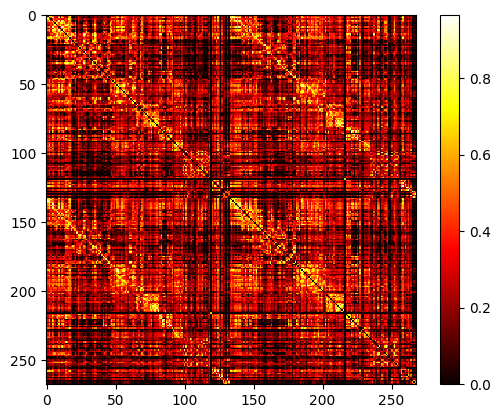

In [21]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [22]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/moritz_deep4/old_scheduler_tanhrelu.csv')

# Cross Validation

In [12]:
from evaluation_fn import evaluate_predictions
from data_preparation import generate_histogram, generate_heatmap

def validation(up_changer, testloader, val_adj_hr, histogram=False, heatmap=False, statement=None):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    if histogram:
        if statement:
            print(statement)
        else:
            print(f'Histogram for Current Fold')
        generate_histogram(val_predictions.cpu(), val_adj_hr.cpu())
    if heatmap:
        if statement:
            print(statement)
        else:
            print(f'First Difference Heatmap for Current Fold')
        generate_heatmap((val_adj_hr[0].cpu() - val_predictions[0].cpu()))

    return {'eval': evaluate_predictions(val_predictions, val_adj_hr), 'preds': val_predictions}

In [13]:
def cross_validate(epochs, early, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, channels_ls = [32, 64], histogram=False, heatmap=False):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=num_steps)
        channels_ls = channels_ls

        up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
        reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))
        
        losses = None
        completed = 0
        remaining = epochs
        val_metrics = {}
        if early>0 and early<epochs:
            up_changer, down_changer, losses = train(epochs-early, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer)

            testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
            val_metrics[f'{epochs-early}'] = validation(up_changer, testloader, val_adj_hr, histogram, heatmap, statement=f'Currrent Fold after {epochs-early}')
            completed = epochs-early
            remaining = early

        up_changer, down_changer, losses = train(remaining, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=completed, loss_log=losses)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics[f'{epochs}'] = validation(up_changer, testloader, val_adj_hr, histogram, heatmap)
        val_metrics['losses'] = losses


        runs_results.append(val_metrics)

    return runs_results

In [14]:
import gc

# del up_changer
# del down_changer
# del test_predictions
gc.collect()

torch.cuda.empty_cache()

results = cross_validate(200,50,16, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=12, histogram=True, heatmap=True)

100%|██████████| 7/7 [00:21<00:00,  3.06s/it]


ep 0: down loss = 0.20765807798930577, up loss = 0.14897599390574864, reconst.loss = 0.29593101143836975, down adj mae = 0.27063258843762533, up adj mae = 0.305698356458119


100%|██████████| 7/7 [00:14<00:00,  2.11s/it]


ep 1: down loss = 0.18639143237045833, up loss = 0.12062126930270876, reconst.loss = 0.26077366726739065, down adj mae = 0.24207639694213867, up adj mae = 0.2725461721420288


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


ep 2: down loss = 0.17179472957338607, up loss = 0.10472881581102099, reconst.loss = 0.23950915464333125, down adj mae = 0.22303746002061026, up adj mae = 0.2458245243344988


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


ep 3: down loss = 0.17106372543743678, up loss = 0.0993918286902564, reconst.loss = 0.22903165008340562, down adj mae = 0.22835752155099595, up adj mae = 0.24053898027965


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


ep 4: down loss = 0.1590492853096553, up loss = 0.08703130909374782, reconst.loss = 0.2137324150119509, down adj mae = 0.21654257391180312, up adj mae = 0.22177022056920187


100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


ep 5: down loss = 0.154453843832016, up loss = 0.07686690773282732, reconst.loss = 0.19617540069988795, down adj mae = 0.20610649457999639, up adj mae = 0.20488550194672175


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


ep 6: down loss = 0.1556919983455113, up loss = 0.07606925921780723, reconst.loss = 0.19030246351446425, down adj mae = 0.20676378267151968, up adj mae = 0.19633563501494272


100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


ep 7: down loss = 0.1453263120991843, up loss = 0.07026117188589913, reconst.loss = 0.17955473703997477, down adj mae = 0.1948999570948737, up adj mae = 0.18791543798787252


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


ep 8: down loss = 0.1377581251519067, up loss = 0.06427970794694764, reconst.loss = 0.17562398740223475, down adj mae = 0.1928077574287142, up adj mae = 0.17484342626162938


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


ep 9: down loss = 0.13580122590065002, up loss = 0.06530454116208213, reconst.loss = 0.17419297141688211, down adj mae = 0.19679513786520278, up adj mae = 0.1826560433421816


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


ep 10: down loss = 0.13049579092434474, up loss = 0.06358060879366738, reconst.loss = 0.1698651760816574, down adj mae = 0.18554022695337022, up adj mae = 0.17446102840559824


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


ep 11: down loss = 0.12324603859867368, up loss = 0.06309377508504051, reconst.loss = 0.16823195772511618, down adj mae = 0.17974049278667995, up adj mae = 0.1732577724116189


 29%|██▊       | 2/7 [00:03<00:09,  1.91s/it]